In [4]:
# ==================== Phase 4: Deep Learning方法 (Mel-Spectrogram + CNN) ====================
print("="*60)
print("Phase 4: Deep Learning - Mel频谱图 + CNN")
print("="*60)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

# 检查MPS (Metal Performance Shaders) 是否可用
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"✓ 使用Metal加速 (Apple Silicon)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✓ 使用CUDA加速")
else:
    device = torch.device("cpu")
    print(f"✓ 使用CPU")

print(f"PyTorch版本: {torch.__version__}")
print(f"设备: {device}")


Phase 4: Deep Learning - Mel频谱图 + CNN
✓ 使用Metal加速 (Apple Silicon)
PyTorch版本: 2.9.0
设备: mps


In [6]:
# ==================== 加载数据 ====================
print("\n加载数据...")

# 数据路径
data_path = '/Users/panmingh/Code/ML_Coursework/Data/MLEndHWII_sample_800'

# 检查路径
if not os.path.exists(data_path):
    raise FileNotFoundError(f"数据路径不存在: {data_path}")

# 加载文件列表
files = glob.glob(os.path.join(data_path, '*.wav'))
print(f'总文件数: {len(files)}')

# 解析文件名，构建DataFrame
data = []
for f in files:
    name = f.split('/')[-1]
    parts = name.split('_')
    song = parts[3].split('.')[0]
    data.append([name, parts[0], parts[1], parts[2], song, f])

df = pd.DataFrame(data, columns=['file', 'participant', 'type', 'number', 'song', 'path']).set_index('file')

print(f"\n数据集统计:")
print(f"总样本数: {len(df)}")
print(f"参与者数量: {df['participant'].nunique()}")
print(f"歌曲数量: {df['song'].nunique()}")
print(f"\n歌曲列表:")
print(df['song'].value_counts().sort_index())



加载数据...
总文件数: 800

数据集统计:
总样本数: 800
参与者数量: 120
歌曲数量: 8

歌曲列表:
song
Feeling          100
Friend           100
Happy            100
Married          100
Necessities      100
NewYork          100
RememberMe       100
TryEverything    100
Name: count, dtype: int64


In [7]:
# ==================== 数据分割（按参与者） ====================
print("\n数据分割（按参与者分组，避免数据泄漏）...")

from sklearn.model_selection import train_test_split

# 标签编码
le = LabelEncoder()
df['label'] = le.fit_transform(df['song'])

print(f"标签映射: {dict(zip(le.classes_, range(len(le.classes_))))}")

# 按参与者分组
unique_participants = df['participant'].unique()
np.random.seed(42)
np.random.shuffle(unique_participants)

# 分割参与者：train 64%, val 16%, test 20%
n_total = len(unique_participants)
n_test = int(0.2 * n_total)
n_val = int(0.16 * n_total)

test_participants = unique_participants[:n_test]
val_participants = unique_participants[n_test:n_test+n_val]
train_participants = unique_participants[n_test+n_val:]

# 根据参与者创建数据集分割
train_df = df[df['participant'].isin(train_participants)].copy()
val_df = df[df['participant'].isin(val_participants)].copy()
test_df = df[df['participant'].isin(test_participants)].copy()

print(f"\n数据分割结果:")
print(f"训练集: {len(train_df)} 样本 ({len(train_participants)} 参与者)")
print(f"验证集: {len(val_df)} 样本 ({len(val_participants)} 参与者)")
print(f"测试集: {len(test_df)} 样本 ({len(test_participants)} 参与者)")

# 验证每个split中每首歌的分布
print(f"\n训练集歌曲分布:")
print(train_df['song'].value_counts().sort_index())



数据分割（按参与者分组，避免数据泄漏）...
标签映射: {'Feeling': 0, 'Friend': 1, 'Happy': 2, 'Married': 3, 'Necessities': 4, 'NewYork': 5, 'RememberMe': 6, 'TryEverything': 7}

数据分割结果:
训练集: 511 样本 (77 参与者)
验证集: 129 样本 (19 参与者)
测试集: 160 样本 (24 参与者)

训练集歌曲分布:
song
Feeling          66
Friend           62
Happy            64
Married          64
Necessities      63
NewYork          66
RememberMe       62
TryEverything    64
Name: count, dtype: int64



4.1 验证Mel频谱图提取

测试文件: S103_whistle_2_Necessities.wav
歌曲: Necessities
原始波形: torch.Size([1, 828352]), 采样率: 48000
处理后波形: torch.Size([1, 661500])
Mel频谱图shape: torch.Size([1, 128, 1292])


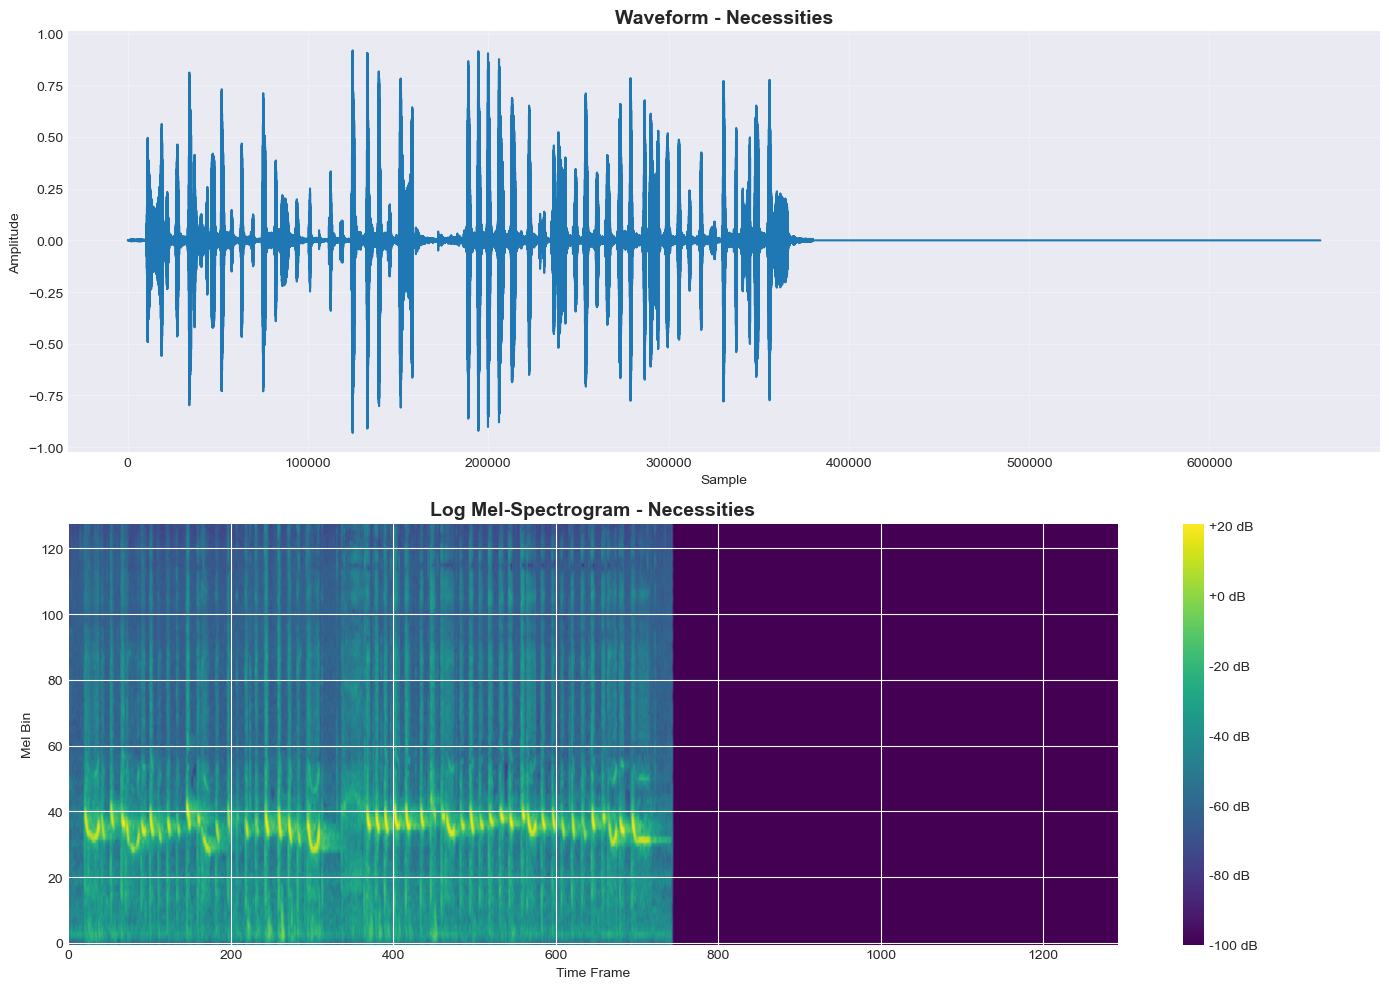


✓ Mel频谱图提取成功!
最终shape: torch.Size([1, 128, 1292])
预期输入CNN的shape: (batch, 1, 128, 1292)


In [11]:
# ==================== 4.1 Mel频谱图提取验证 ====================
print("\n4.1 验证Mel频谱图提取")

import librosa  # 添加这个导入

# 定义Mel频谱图转换参数
MEL_SPEC_CONFIG = {
    'sample_rate': 22050,
    'n_fft': 2048,
    'hop_length': 512,
    'n_mels': 128,
    'duration': 30,  # 秒
}

# 创建Mel频谱图转换器
mel_transform = T.MelSpectrogram(
    sample_rate=MEL_SPEC_CONFIG['sample_rate'],
    n_fft=MEL_SPEC_CONFIG['n_fft'],
    hop_length=MEL_SPEC_CONFIG['hop_length'],
    n_mels=MEL_SPEC_CONFIG['n_mels'],
    normalized=True
)

# 测试单个音频文件
test_file = train_df.iloc[0]['path']
test_song = train_df.iloc[0]['song']
print(f"\n测试文件: {train_df.iloc[0].name}")
print(f"歌曲: {test_song}")

# ⭐ 使用librosa加载音频（更兼容）
waveform_np, sr = librosa.load(test_file, sr=None)  # sr=None保持原始采样率
waveform = torch.from_numpy(waveform_np).unsqueeze(0)  # 转为torch tensor，添加channel维度

print(f"原始波形: {waveform.shape}, 采样率: {sr}")

# 如果是立体声，转为单声道（librosa.load默认已经是单声道，但保险起见）
if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)

# Resample到目标采样率
if sr != MEL_SPEC_CONFIG['sample_rate']:
    resampler = T.Resample(sr, MEL_SPEC_CONFIG['sample_rate'])
    waveform = resampler(waveform)
    sr = MEL_SPEC_CONFIG['sample_rate']

# 裁剪或填充到固定长度
target_length = MEL_SPEC_CONFIG['sample_rate'] * MEL_SPEC_CONFIG['duration']
if waveform.shape[1] > target_length:
    waveform = waveform[:, :target_length]
elif waveform.shape[1] < target_length:
    padding = target_length - waveform.shape[1]
    waveform = F.pad(waveform, (0, padding))

print(f"处理后波形: {waveform.shape}")

# 提取Mel频谱图
mel_spec = mel_transform(waveform)
print(f"Mel频谱图shape: {mel_spec.shape}")  # 应该是 (1, 128, time_steps)

# 转为对数刻度 (log mel-spectrogram)
mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)

# 可视化
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 上图：原始波形
axes[0].plot(waveform[0].numpy())
axes[0].set_title(f'Waveform - {test_song}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sample')
axes[0].set_ylabel('Amplitude')
axes[0].grid(alpha=0.3)

# 下图：Mel频谱图
img = axes[1].imshow(mel_spec_db[0].numpy(), aspect='auto', origin='lower', cmap='viridis')
axes[1].set_title(f'Log Mel-Spectrogram - {test_song}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time Frame')
axes[1].set_ylabel('Mel Bin')
plt.colorbar(img, ax=axes[1], format='%+2.0f dB')

plt.tight_layout()
plt.show()

print(f"\n✓ Mel频谱图提取成功!")
print(f"最终shape: {mel_spec_db.shape}")
print(f"预期输入CNN的shape: (batch, 1, 128, {mel_spec_db.shape[2]})")



4.1.1 可视化不同歌曲的Mel频谱图


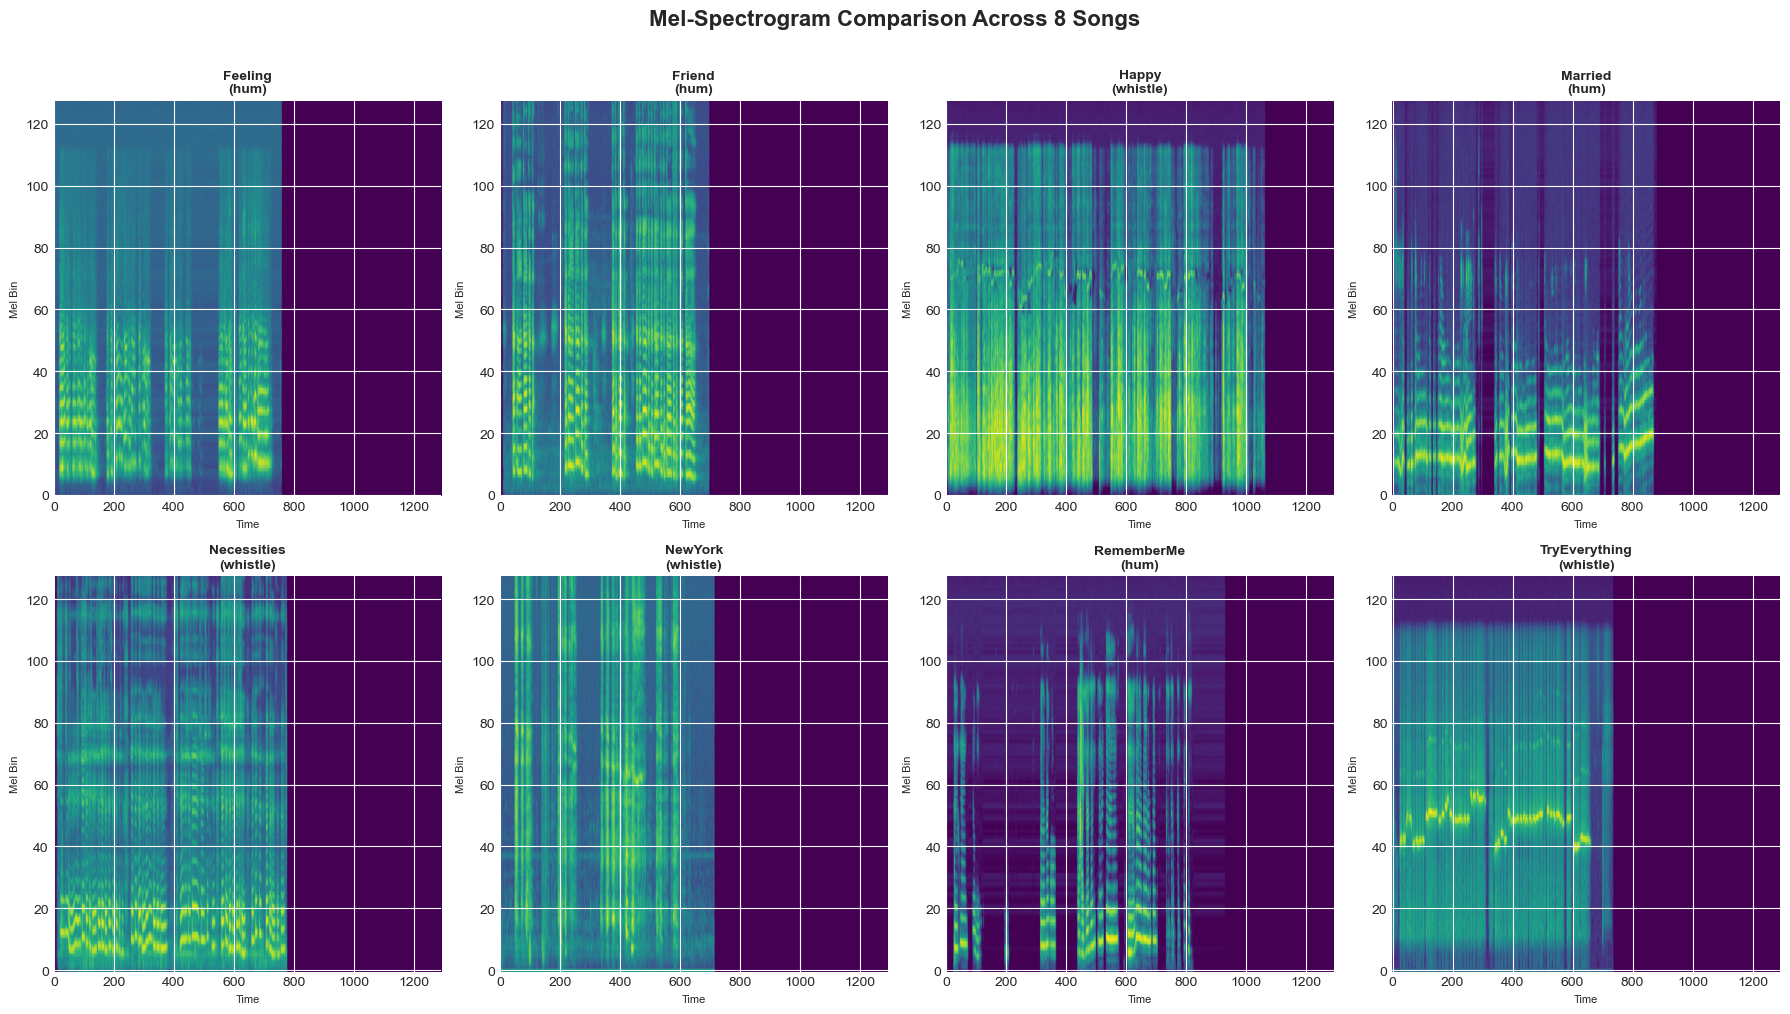


观察:
- 不同歌曲的频谱图是否有明显的视觉差异？
- 哪些歌曲的频谱模式看起来相似（可能容易混淆）？
- Hum和Whistle在频谱上的差异是否明显？


In [12]:
# ==================== 4.1.1 可视化不同歌曲的Mel频谱图对比 ====================
print("\n4.1.1 可视化不同歌曲的Mel频谱图")

# 每首歌随机抽一个样本
sample_files = []
for song in le.classes_:
    song_files = train_df[train_df['song'] == song].sample(1, random_state=42)
    sample_files.append(song_files.iloc[0])

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for idx, file_info in enumerate(sample_files):
    # 加载和处理
    waveform_np, sr = librosa.load(file_info['path'], sr=None)
    waveform = torch.from_numpy(waveform_np).unsqueeze(0)
    
    if sr != MEL_SPEC_CONFIG['sample_rate']:
        resampler = T.Resample(sr, MEL_SPEC_CONFIG['sample_rate'])
        waveform = resampler(waveform)
    
    # 裁剪/填充
    target_length = MEL_SPEC_CONFIG['sample_rate'] * MEL_SPEC_CONFIG['duration']
    if waveform.shape[1] > target_length:
        waveform = waveform[:, :target_length]
    elif waveform.shape[1] < target_length:
        padding = target_length - waveform.shape[1]
        waveform = F.pad(waveform, (0, padding))
    
    # Mel频谱图
    mel_spec = mel_transform(waveform)
    mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
    
    # 可视化
    img = axes[idx].imshow(mel_spec_db[0].numpy(), aspect='auto', origin='lower', cmap='viridis')
    axes[idx].set_title(f'{file_info["song"]}\n({file_info["type"]})', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Time', fontsize=8)
    axes[idx].set_ylabel('Mel Bin', fontsize=8)

plt.suptitle('Mel-Spectrogram Comparison Across 8 Songs', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("\n观察:")
print("- 不同歌曲的频谱图是否有明显的视觉差异？")
print("- 哪些歌曲的频谱模式看起来相似（可能容易混淆）？")
print("- Hum和Whistle在频谱上的差异是否明显？")



4.2 实现数据增强函数

测试数据增强效果...


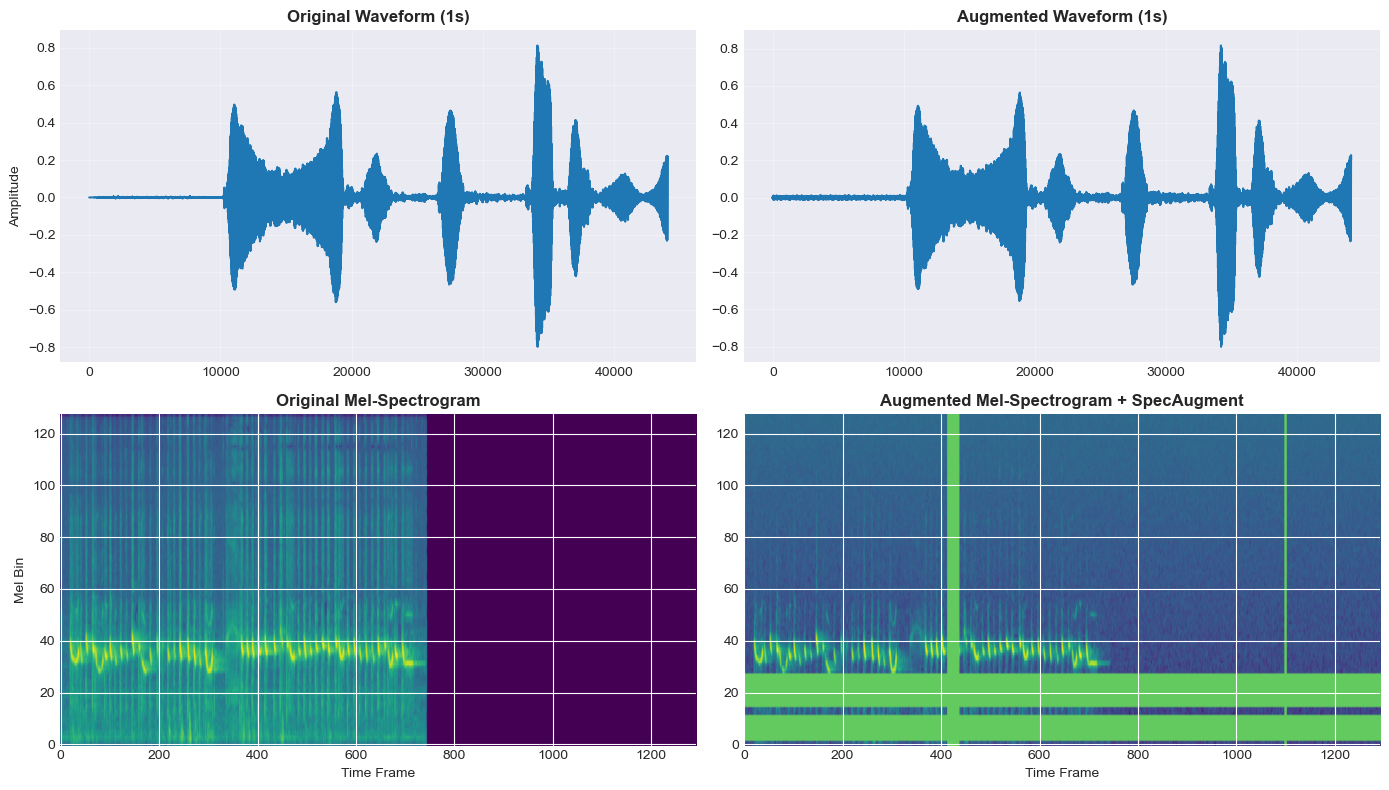


✓ 数据增强功能验证成功!
观察: 增强后的波形和频谱图与原始版本有明显差异，但保留了核心特征


In [13]:
# ==================== 4.2 数据增强实现 ====================
print("\n4.2 实现数据增强函数")

class AudioAugmentation:
    """音频数据增强类"""
    
    def __init__(self, sample_rate=22050):
        self.sr = sample_rate
        
    def time_stretch(self, waveform, rate_range=(0.8, 1.2)):
        """时间拉伸：改变速度但不改变音高"""
        rate = np.random.uniform(rate_range[0], rate_range[1])
        waveform_np = waveform.squeeze(0).numpy()
        stretched = librosa.effects.time_stretch(waveform_np, rate=rate)
        return torch.from_numpy(stretched).unsqueeze(0)
    
    def pitch_shift(self, waveform, n_steps_range=(-2, 2)):
        """音高偏移：上下偏移半音"""
        n_steps = np.random.uniform(n_steps_range[0], n_steps_range[1])
        waveform_np = waveform.squeeze(0).numpy()
        shifted = librosa.effects.pitch_shift(waveform_np, sr=self.sr, n_steps=n_steps)
        return torch.from_numpy(shifted).unsqueeze(0)
    
    def add_noise(self, waveform, noise_factor_range=(0.001, 0.005)):
        """添加高斯白噪声"""
        noise_factor = np.random.uniform(noise_factor_range[0], noise_factor_range[1])
        noise = torch.randn_like(waveform) * noise_factor
        return waveform + noise
    
    def spec_augment(self, mel_spec, freq_mask_param=15, time_mask_param=35, n_freq_masks=1, n_time_masks=1):
        """SpecAugment: 在频谱图上应用频率和时间遮盖"""
        # 频率遮盖
        for _ in range(n_freq_masks):
            freq_mask = T.FrequencyMasking(freq_mask_param)
            mel_spec = freq_mask(mel_spec)
        
        # 时间遮盖
        for _ in range(n_time_masks):
            time_mask = T.TimeMasking(time_mask_param)
            mel_spec = time_mask(mel_spec)
        
        return mel_spec
    
    def __call__(self, waveform, apply_spec_aug=False, mel_spec=None):
        """
        随机应用一种或多种增强
        waveform: (1, time)
        """
        # 随机选择应用哪些增强（50%概率）
        if np.random.random() > 0.5:
            waveform = self.time_stretch(waveform)
        
        if np.random.random() > 0.5:
            waveform = self.pitch_shift(waveform)
        
        if np.random.random() > 0.5:
            waveform = self.add_noise(waveform)
        
        # SpecAugment应用在Mel频谱图上
        if apply_spec_aug and mel_spec is not None:
            mel_spec = self.spec_augment(mel_spec)
            return waveform, mel_spec
        
        return waveform

# 测试数据增强
print("\n测试数据增强效果...")
augmentor = AudioAugmentation(sample_rate=MEL_SPEC_CONFIG['sample_rate'])

# 加载测试样本
test_waveform_np, sr = librosa.load(train_df.iloc[0]['path'], sr=MEL_SPEC_CONFIG['sample_rate'])
test_waveform = torch.from_numpy(test_waveform_np).unsqueeze(0)

# 裁剪到固定长度
target_length = MEL_SPEC_CONFIG['sample_rate'] * MEL_SPEC_CONFIG['duration']
if test_waveform.shape[1] > target_length:
    test_waveform = test_waveform[:, :target_length]
else:
    test_waveform = F.pad(test_waveform, (0, target_length - test_waveform.shape[1]))

# 应用增强
aug_waveform = augmentor(test_waveform.clone())

# 对比可视化
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 原始波形
axes[0, 0].plot(test_waveform[0].numpy()[:44100])  # 只显示前1秒
axes[0, 0].set_title('Original Waveform (1s)', fontweight='bold')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].grid(alpha=0.3)

# 增强后波形
axes[0, 1].plot(aug_waveform[0].numpy()[:44100])
axes[0, 1].set_title('Augmented Waveform (1s)', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 原始Mel频谱图
mel_orig = mel_transform(test_waveform)
mel_orig_db = torchaudio.transforms.AmplitudeToDB()(mel_orig)
axes[1, 0].imshow(mel_orig_db[0].numpy(), aspect='auto', origin='lower', cmap='viridis')
axes[1, 0].set_title('Original Mel-Spectrogram', fontweight='bold')
axes[1, 0].set_ylabel('Mel Bin')
axes[1, 0].set_xlabel('Time Frame')

# 增强后Mel频谱图（含SpecAugment）
mel_aug = mel_transform(aug_waveform)
mel_aug_db = torchaudio.transforms.AmplitudeToDB()(mel_aug)
mel_aug_db_masked = augmentor.spec_augment(mel_aug_db, n_freq_masks=2, n_time_masks=2)
axes[1, 1].imshow(mel_aug_db_masked[0].numpy(), aspect='auto', origin='lower', cmap='viridis')
axes[1, 1].set_title('Augmented Mel-Spectrogram + SpecAugment', fontweight='bold')
axes[1, 1].set_xlabel('Time Frame')

plt.tight_layout()
plt.show()

print("\n✓ 数据增强功能验证成功!")
print("观察: 增强后的波形和频谱图与原始版本有明显差异，但保留了核心特征")


In [16]:
# ==================== 4.3 创建PyTorch Dataset ====================
print("\n4.3 创建PyTorch Dataset")

class MelSpectrogramDataset(Dataset):
    """Mel频谱图数据集"""
    
    def __init__(self, dataframe, mel_transform, config, augment=False, target_time_steps=128):
        """
        dataframe: 包含path和label的DataFrame
        mel_transform: Mel频谱图转换器
        config: MEL_SPEC_CONFIG
        augment: 是否应用数据增强
        target_time_steps: 目标时间步数（会resize到这个大小）
        """
        self.df = dataframe.reset_index(drop=True)
        self.mel_transform = mel_transform
        self.config = config
        self.augment = augment
        self.target_time_steps = target_time_steps
        
        if augment:
            self.augmentor = AudioAugmentation(config['sample_rate'])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # 获取文件路径和标签
        file_path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['label']
        
        # 加载音频
        waveform_np, sr = librosa.load(file_path, sr=self.config['sample_rate'])
        waveform = torch.from_numpy(waveform_np).unsqueeze(0).float()
        
        # 裁剪/填充到固定长度
        target_length = self.config['sample_rate'] * self.config['duration']
        if waveform.shape[1] > target_length:
            waveform = waveform[:, :target_length]
        elif waveform.shape[1] < target_length:
            waveform = F.pad(waveform, (0, target_length - waveform.shape[1]))
        
        # 数据增强（仅训练集）
        if self.augment:
            waveform = self.augmentor(waveform)
        
        # 提取Mel频谱图
        mel_spec = self.mel_transform(waveform)
        mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
        
        # SpecAugment（仅训练集）
        if self.augment:
            mel_spec_db = self.augmentor.spec_augment(
                mel_spec_db, 
                freq_mask_param=15, 
                time_mask_param=35,
                n_freq_masks=2,
                n_time_masks=2
            )
        
        # ⭐ 重要：Resize到固定的时间步数，避免batch size不一致
        # mel_spec_db shape: (1, n_mels, time_steps)
        mel_spec_db = F.interpolate(
            mel_spec_db.unsqueeze(0),  # (1, 1, n_mels, time_steps)
            size=(self.config['n_mels'], self.target_time_steps),  # (128, 128)
            mode='bilinear',
            align_corners=False
        ).squeeze(0)  # 回到 (1, 128, 128)
        
        # 归一化到[-1, 1]
        mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-8)
        
        return mel_spec_db, label

# 创建数据集（设置target_time_steps=128，得到方形频谱图）
print("\n创建训练/验证/测试数据集...")
train_dataset = MelSpectrogramDataset(train_df, mel_transform, MEL_SPEC_CONFIG, augment=True, target_time_steps=128)
val_dataset = MelSpectrogramDataset(val_df, mel_transform, MEL_SPEC_CONFIG, augment=False, target_time_steps=128)
test_dataset = MelSpectrogramDataset(test_df, mel_transform, MEL_SPEC_CONFIG, augment=False, target_time_steps=128)

print(f"训练集: {len(train_dataset)} 样本")
print(f"验证集: {len(val_dataset)} 样本")
print(f"测试集: {len(test_dataset)} 样本")

# 测试Dataset
sample_mel, sample_label = train_dataset[0]
print(f"\n样本形状: {sample_mel.shape}")
print(f"样本标签: {sample_label} ({le.classes_[sample_label]})")

# 创建DataLoader
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n✓ DataLoader创建成功")
print(f"训练批次数: {len(train_loader)}")
print(f"验证批次数: {len(val_loader)}")
print(f"测试批次数: {len(test_loader)}")

# 测试batch一致性
test_batch, test_labels = next(iter(train_loader))
print(f"\n测试batch形状: {test_batch.shape}")
print(f"✓ Batch大小一致，可以正常训练!")



4.3 创建PyTorch Dataset

创建训练/验证/测试数据集...
训练集: 511 样本
验证集: 129 样本
测试集: 160 样本

样本形状: torch.Size([1, 128, 128])
样本标签: 4 (Necessities)

✓ DataLoader创建成功
训练批次数: 32
验证批次数: 9
测试批次数: 10

测试batch形状: torch.Size([16, 1, 128, 128])
✓ Batch大小一致，可以正常训练!


In [17]:
# ==================== 4.4 定义CNN模型 ====================
print("\n4.4 定义CNN模型架构")

class MelSpectrogramCNN(nn.Module):
    """
    轻量级CNN用于Mel频谱图分类
    输入: (batch, 1, 128, time_steps)
    输出: (batch, num_classes)
    """
    
    def __init__(self, num_classes=8, dropout_rate=0.5):
        super(MelSpectrogramCNN, self).__init__()
        
        # 第一个卷积块
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (batch, 32, 64, time/2)
        )
        
        # 第二个卷积块
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (batch, 64, 32, time/4)
        )
        
        # 第三个卷积块
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (batch, 128, 16, time/8)
        )
        
        # 第四个卷积块（可选，增加模型容量）
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (batch, 256, 8, time/16)
        )
        
        # 全局平均池化
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # (batch, 256, 1, 1)
        
        # 分类头
        self.classifier = nn.Sequential(
            nn.Flatten(),  # (batch, 256)
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        """
        x: (batch, 1, 128, time_steps)
        """
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x

# 创建模型
model = MelSpectrogramCNN(num_classes=len(le.classes_), dropout_rate=0.5)
model = model.to(device)

print(f"✓ 模型创建成功")
print(f"模型设备: {next(model.parameters()).device}")

# 模型结构摘要
print(f"\n模型架构:")
print(model)

# 计算参数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n总参数量: {total_params:,}")
print(f"可训练参数: {trainable_params:,}")

# 测试前向传播
with torch.no_grad():
    sample_batch, _ = next(iter(train_loader))
    sample_batch = sample_batch.to(device)
    output = model(sample_batch)
    print(f"\n前向传播测试:")
    print(f"输入形状: {sample_batch.shape}")
    print(f"输出形状: {output.shape}")
    print(f"✓ 模型可以正常运行!")



4.4 定义CNN模型架构
✓ 模型创建成功
模型设备: mps:0

模型架构:
MelSpectrogramCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3,

In [18]:
# ==================== 4.5 训练和评估函数 ====================
print("\n4.5 定义训练和评估函数")

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """训练一个epoch"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 前向传播
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 统计
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # 计算指标
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return epoch_loss, epoch_acc, epoch_f1

def evaluate(model, dataloader, criterion, device):
    """评估模型"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 计算指标
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return epoch_loss, epoch_acc, epoch_f1, all_preds, all_labels

print("✓ 训练和评估函数定义完成")



4.5 定义训练和评估函数
✓ 训练和评估函数定义完成


In [20]:
# ==================== 4.6 训练模型 ====================
print("\n4.6 开始训练CNN模型")

import time
from datetime import datetime

# 训练超参数
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
PATIENCE = 20  # Early stopping patience

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# 学习率调度器（移除了verbose参数）
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=10
)

print(f"训练配置:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Optimizer: Adam")
print(f"  Scheduler: ReduceLROnPlateau")
print(f"  Early Stopping Patience: {PATIENCE}")
print(f"  Device: {device}")

# 训练历史
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

# Early stopping
best_val_acc = 0.0
patience_counter = 0
best_model_state = None

print(f"\n{'='*70}")
print(f"开始训练 - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*70}\n")

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    # 训练
    train_loss, train_acc, train_f1 = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # 验证
    val_loss, val_acc, val_f1, _, _ = evaluate(
        model, val_loader, criterion, device
    )
    
    # 学习率调度
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_acc)
    new_lr = optimizer.param_groups[0]['lr']
    
    # 记录历史
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    # 打印进度
    epoch_time = time.time() - epoch_start
    print(f"Epoch [{epoch+1:3d}/{NUM_EPOCHS}] | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f} | "
          f"Time: {epoch_time:.1f}s")
    
    # 如果学习率改变了，打印提示
    if new_lr < current_lr:
        print(f"  → 学习率降低: {current_lr:.6f} → {new_lr:.6f}")
    
    # Early stopping检查
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"  → 新的最佳验证准确率: {best_val_acc:.4f} ✓")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

total_time = time.time() - start_time
print(f"\n{'='*70}")
print(f"训练完成 - 总用时: {total_time/60:.2f} 分钟")
print(f"最佳验证准确率: {best_val_acc:.4f}")
print(f"{'='*70}\n")

# 加载最佳模型
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("✓ 已加载最佳模型权重")



4.6 开始训练CNN模型
训练配置:
  Epochs: 100
  Learning Rate: 0.001
  Batch Size: 16
  Optimizer: Adam
  Scheduler: ReduceLROnPlateau
  Early Stopping Patience: 20
  Device: mps

开始训练 - 2025-12-18 11:26:05

Epoch [  1/100] | Train Loss: 2.1225 Acc: 0.1350 F1: 0.1237 | Val Loss: 2.0667 Acc: 0.1240 F1: 0.0581 | Time: 48.4s
  → 新的最佳验证准确率: 0.1240 ✓
Epoch [  2/100] | Train Loss: 2.1024 Acc: 0.1096 F1: 0.0925 | Val Loss: 2.1017 Acc: 0.1318 F1: 0.0307 | Time: 45.9s
  → 新的最佳验证准确率: 0.1318 ✓
Epoch [  3/100] | Train Loss: 2.0942 Acc: 0.1213 F1: 0.1066 | Val Loss: 2.0991 Acc: 0.1395 F1: 0.0744 | Time: 45.7s
  → 新的最佳验证准确率: 0.1395 ✓
Epoch [  4/100] | Train Loss: 2.0904 Acc: 0.1233 F1: 0.1086 | Val Loss: 2.0771 Acc: 0.1318 F1: 0.0518 | Time: 45.0s
Epoch [  5/100] | Train Loss: 2.0891 Acc: 0.1311 F1: 0.1059 | Val Loss: 2.0753 Acc: 0.1395 F1: 0.0526 | Time: 45.6s
Epoch [  6/100] | Train Loss: 2.0791 Acc: 0.1507 F1: 0.1084 | Val Loss: 2.0813 Acc: 0.1395 F1: 0.0688 | Time: 44.6s
Epoch [  7/100] | Train Loss: 2.070

KeyboardInterrupt: 

In [ ]:
# ==================== 4.7 训练历史可视化 ====================
print("\n4.7 训练历史可视化")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图: Loss
epochs_range = range(1, len(history['train_loss']) + 1)
axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 右图: Accuracy
axes[1].plot(epochs_range, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
axes[1].plot(epochs_range, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
axes[1].axhline(y=best_val_acc, color='g', linestyle='--', label=f'Best Val Acc: {best_val_acc:.4f}')
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# 分析过拟合情况
final_train_acc = history['train_acc'][-1]
final_val_acc = history['val_acc'][-1]
overfitting_gap = final_train_acc - final_val_acc

print(f"\n训练分析:")
print(f"  最终训练准确率: {final_train_acc:.4f}")
print(f"  最终验证准确率: {final_val_acc:.4f}")
print(f"  Train-Val Gap: {overfitting_gap:.4f}")

if overfitting_gap > 0.1:
    print(f"  ⚠️  存在过拟合迹象 (gap > 0.1)")
elif overfitting_gap < 0:
    print(f"  ⚠️  验证集表现优于训练集，可能需要检查数据")
else:
    print(f"  ✓ 模型泛化良好")
